#  Прогнозирование заказов такси

**Описание проекта**: Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель исследования**: Построить модель машинного обучения для предсказания количества заказов такси на следующий час.

**Ход исследования:**

- *Шаг 1.* Подготовка и предобработка данных.
- *Шаг 2.* Исследовательский анализ данных. 
- *Шаг 3.* Обучение модели.
- *Шаг 4.* Тестирование и анализ модели.
- *Шаг 4.* Выводы.

**Общий вывод**: По итогам проведенного анализа и разработки модели машинного обучения появится возможность спрогнозировать количество заказов такси на следующий час. 

**Описание данных**

Данные имеют следующие признаки:
- `num_orders` — количество заказов.


## Подготовка и предобработка данных

### Импортирование библиотек

In [1]:
# Установим библиотеки, которые понадобятся для работы над проектом. 
!pip install -q lightgbm
!pip install -q catboost

# Обновляем scikit-learn, так как выдавал ошибки
!pip install -Uq scikit-learn

In [2]:
# Импортируем библиотеки, которые понадобятся для работы над проектом. 
import time
import warnings
import math

# для датафрейма 
import pandas as pd
import numpy as np

# для статистики
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# для визуализации 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# для машинного обучения
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit  
from sklearn.pipeline import Pipeline

# модели 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

# метрики
from sklearn.metrics import mean_squared_error

In [3]:
# Зафисируем константы

RANDOM_STATE = 42

### Загрузка данных 

In [4]:
# Считаем данные из csv-файла в датафрейм и сохраним в переменную. 

try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
# Функция вывода основной информации о файлах-датафреймах

def main_info(df):
    # Информация о структуре датафрейма
    print("Информация о структурах:")
    display(df.info())
    print("\n")
    display(df.shape)
    print('-----')
    
    # Статистическое описание колонок
    print("Статистика:")
    display(df.describe().T)
    print("\n")
    print('-----')
    
    # Первые десять строк датафрейма
    print("Первые строки:")
    display(df.head(10))
    print("\n")
    print('-----')
    
    # Информация о дубликатах
    print("Количество явных дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print("\n")
    print('-----')
    
    # Информация о пропусках
    print("Количество пропусков в датафрейме:")
    display(df.isna().sum())
    print("\n")
    print('-----')

In [6]:
# Выведем основную информацию о датафрейме df

main_info(df_taxi)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

(26496, 1)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0




-----
Первые строки:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17




-----
Количество явных дубликатов в датафрейме:


26415



-----
Количество пропусков в датафрейме:


num_orders    0
dtype: int64



-----


**Комментарии**

Датасет из файла `taxi.csv` мы сохранили в переменную `df_taxi`. Он содержит 26 496  строк и 1 столбец. Пропусков в данных нет. Названия столбцов соответствуют правилам snake_case. На первый взгляд данные выглядят нормально.

## Исследовательский анализ данных

In [7]:
# Отсортируем данные по времени

df_taxi = df_taxi.sort_index()

# Проверим результат

print(df_taxi.index.is_monotonic)
print(df_taxi.info())
print(df_taxi.head())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


**Комментарии**

В датафрейме представлены исторические данные в период с 1 марта по 31 августа 2018 года. Данные записаны с периодичностью 10 минут, необходимо их ресемплировать с промежутков в 1 час. 

In [8]:
# Ресемплируем выборку по 1 часу

taxi_1h = df_taxi.resample("1H").sum()

# Проверим результат

print(taxi_1h.info())
print(taxi_1h.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


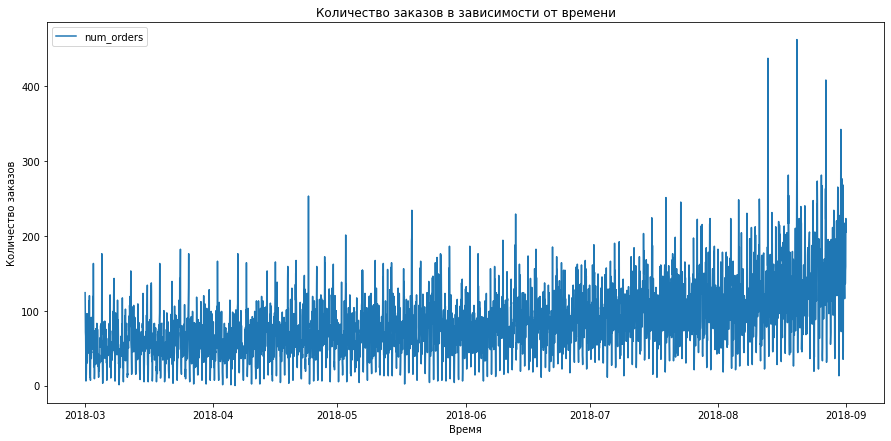

In [9]:
# Построим график 

fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=taxi_1h, ax=ax)
ax.set_xlabel("Время")
ax.set_ylabel("Количество заказов")
ax.set_title("Количество заказов в зависимости от времени")
plt.show()

**Комментарии**

График охватывает период с марта по сентябрь 2018 года. Можно заметить, что количество заказов имеет сезонные колебания. Среднее значение постепенно увеличивается, на свой максимум выходит к концу августа.


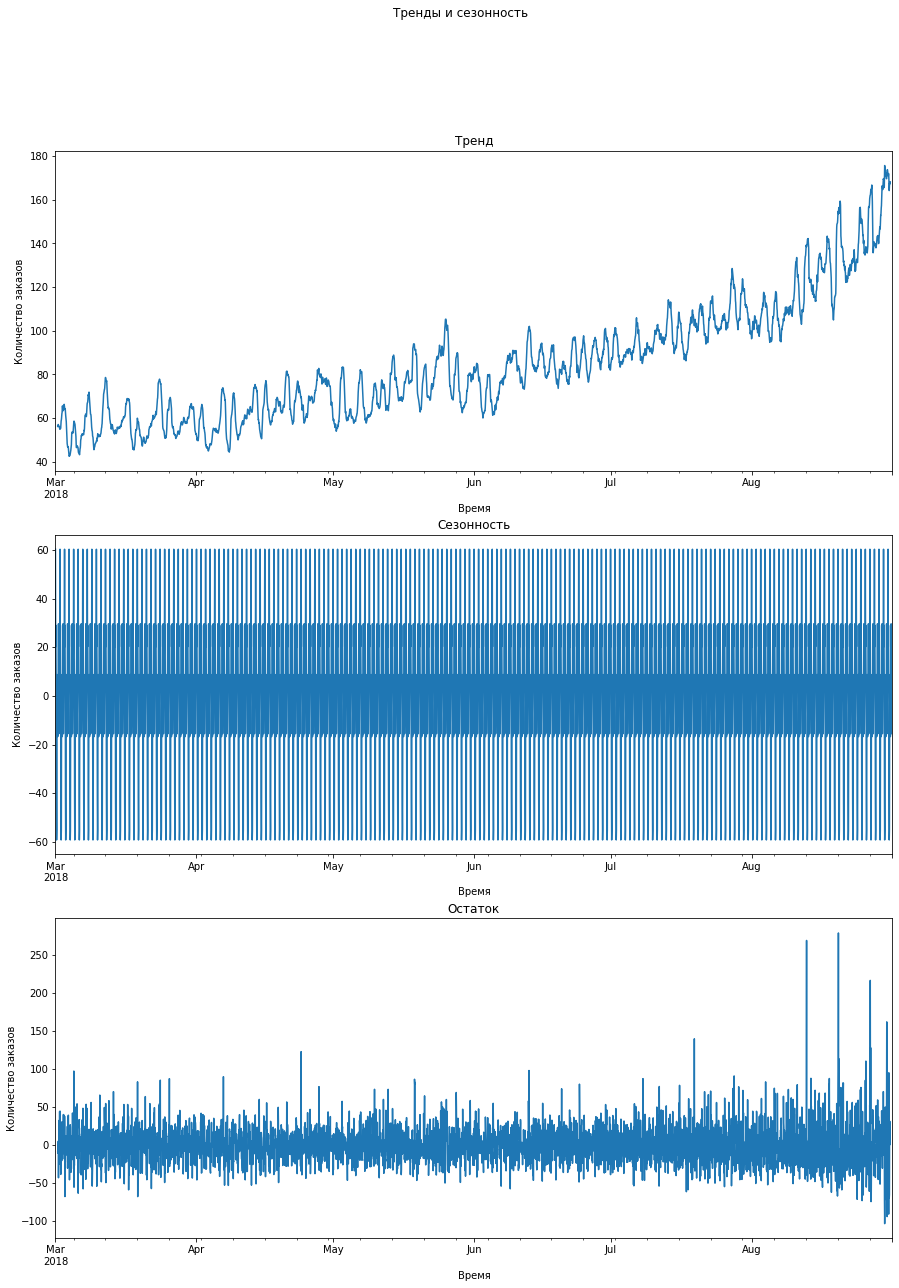

In [10]:
# Изучим тренды и сезонность

decomposed = seasonal_decompose(taxi_1h) 

fig, axs = plt.subplots(3, 1, figsize = (15,20))
decomposed.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

**Комментарии**

Анализируя графики тренда, сезонности и остатков можно сделать следующие выводы: 
- Линия тренда на графике плавно поднимается вверх, что указывает на рост значений с течением времени.
- График сезонности демонстрирует периодические колебания данных, которые повторяются с определенной регулярностью. Эти колебания могут быть связаны с временем суток или днями недели, необходимо подробнее рассмотреть более короткий промежуток времени.
- График показывает остаточные значения после вычитания тренда и сезонности из исходных данных. Остаточные значения представляют собой случайные колебания, которые не могут быть объяснены трендом или сезонностью. На графике видно, что остаточные значения колеблются вокруг нуля, что указывает на отсутствие систематических отклонений.

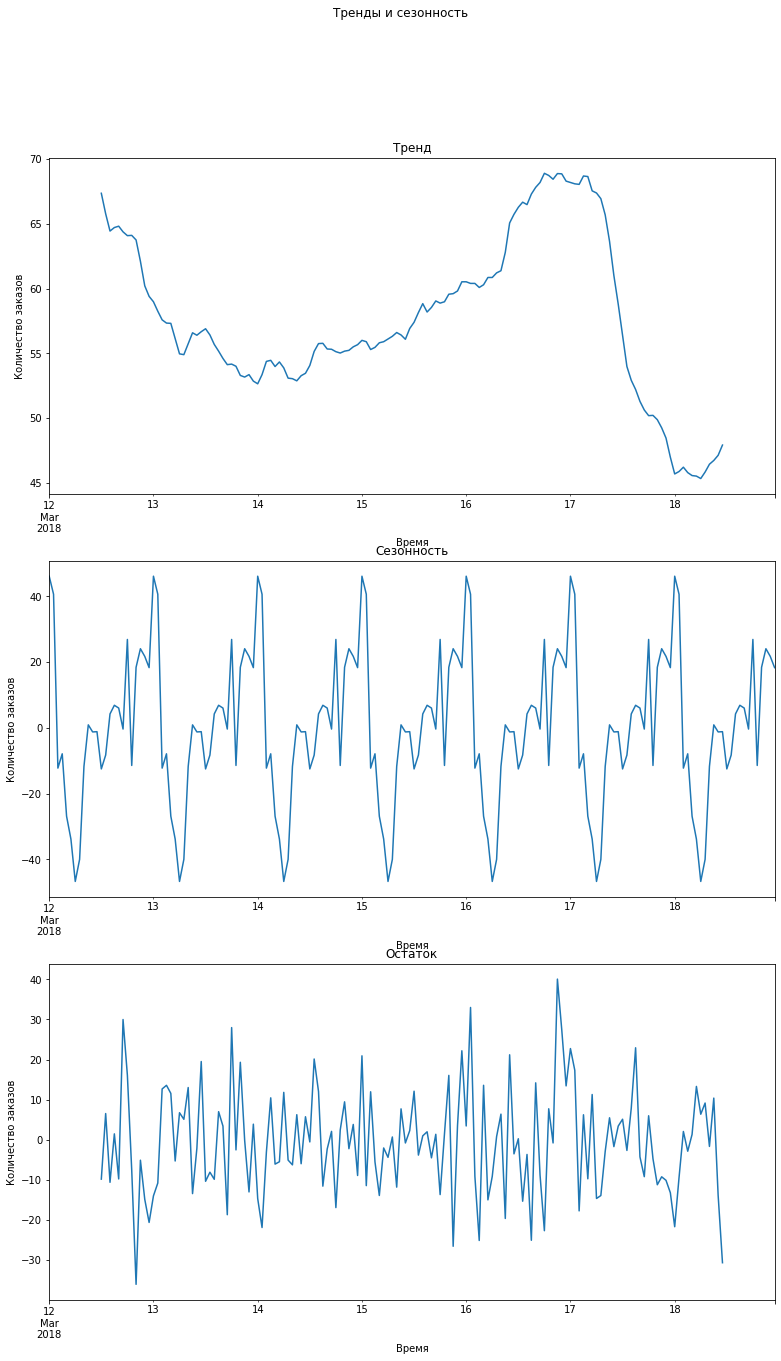

In [11]:
# Изучим тренды и сезонность в течение одной недели

taxi_1week = taxi_1h['2018-03-12':'2018-03-18']

decomposed_week = seasonal_decompose(taxi_1week) 

fig, axs = plt.subplots(3, 1, figsize = (13,21))
decomposed_week.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed_week.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed_week.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

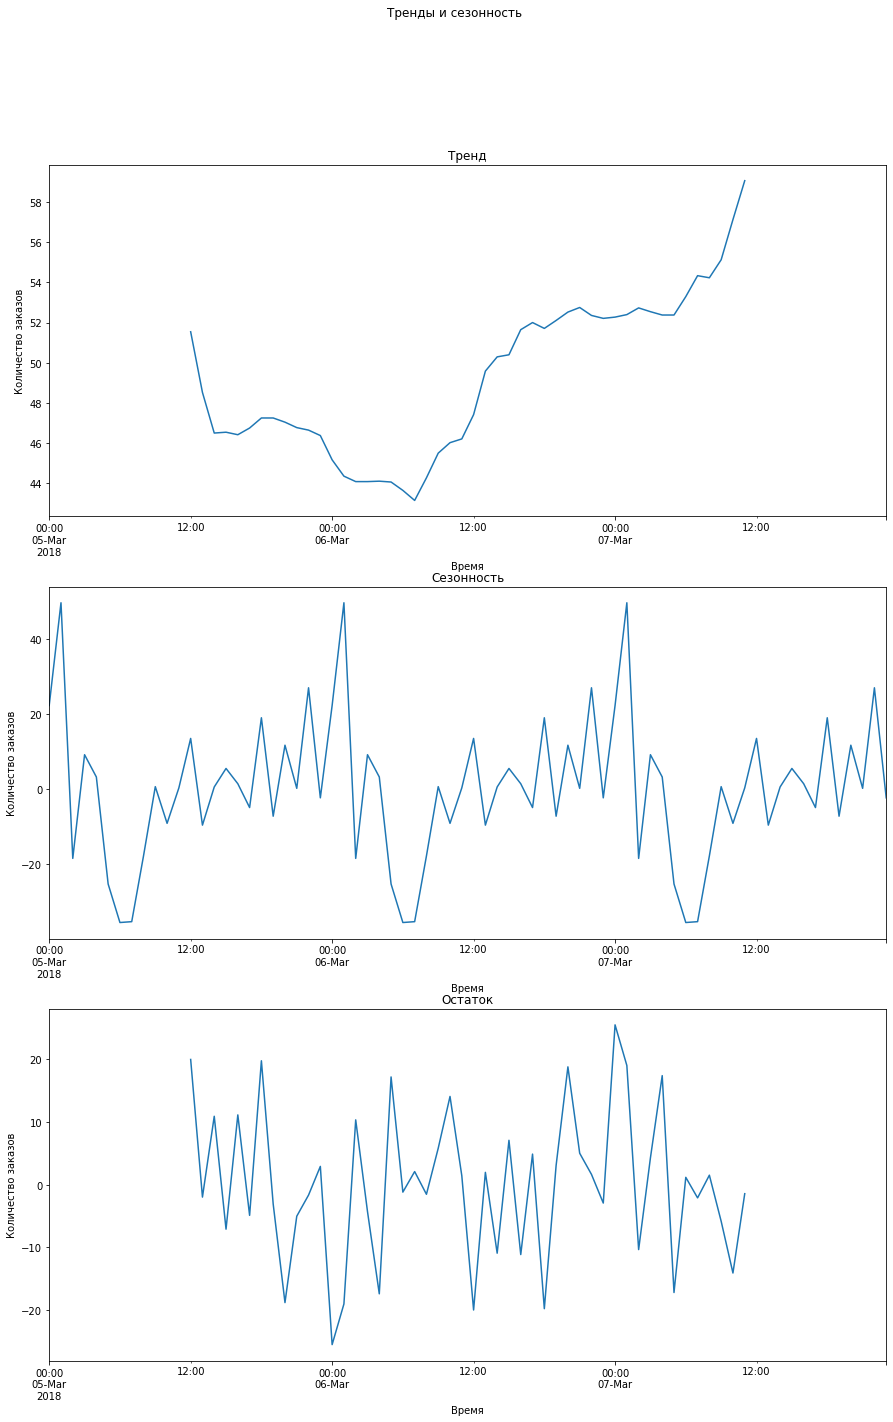

In [12]:
# Изучим тренды и сезонность в течение одного дня

taxi_1day = taxi_1h['2018-03-05':'2018-03-07']

decomposed_day = seasonal_decompose(taxi_1day) 

fig, axs = plt.subplots(3, 1, figsize = (15,22))
decomposed_day.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed_day.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed_day.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

**Комментарии**

Анализируя графики тренда, сезонности и остатков на примере одной недели можно сделать следующие выводы: 
- Линия тренда на графике показывает повышение количества заказов утром в понедельник, затем идет спад и плавный подъем к вечеру пятницы, пик приходится на ночь с пятницы на субботу, затем снова следует резкий спад в воскресенье. Эти колебания вполне объяснимы активностью жителей городов в конце рабочей недели. 
- График сезонности демонстрирует периодические колебания в течение суток. Можно увидеть, что утром, в обед и вечерам нарастает количество заказов. Пик нагрузки приходится на полночь, а затем ночью - она минимальна.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


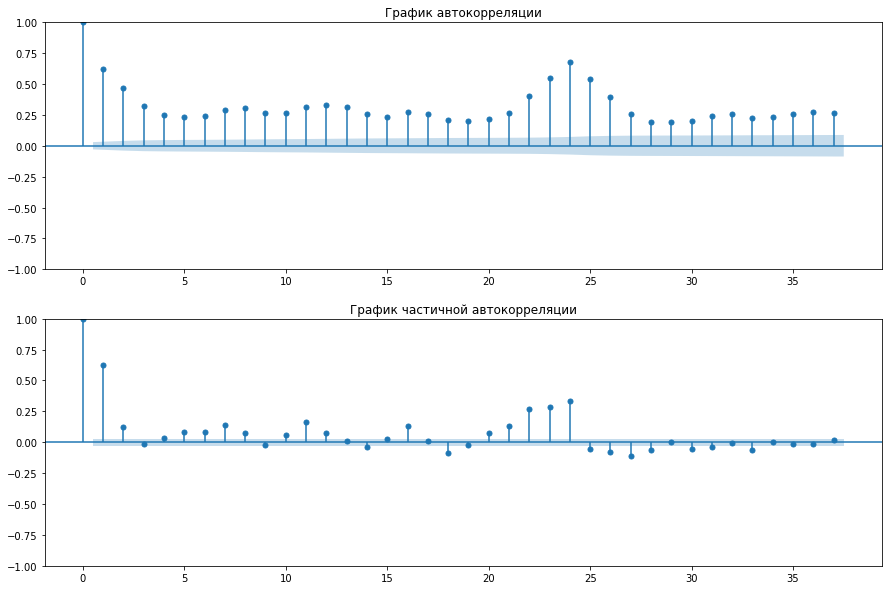

In [13]:
# Построим график автокорреляции и частичной автокорреляции

fig, axs = plt.subplots(2, 1, figsize = (15,10))
plot_acf(taxi_1h, ax=axs[0])
axs[0].set_title('График автокорреляции')
plot_pacf(taxi_1h, ax=axs[1])
axs[1].set_title('График частичной автокорреляции')
plt.show()

In [14]:
# Функция для проверки KPSS критерия

def perform_kpss_test(series):
    result = kpss(series)
    print(f"KPSS-тест")
    print(f"KPSS статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print(f"Критические значения:")
    for key, value in result[3].items():
        print(f"  {key}: {value:.4f}")
    print("Вывод:", end=" ")
    if result[1] <= 0.05:
        print("Временной ряд нестационарен (Отвергаем H0)")
    else:
        print("Временной ряд стационарен (Не отвергаем H0)")
    print()


In [15]:
# Функция для проведение ADF-теста

def perform_adf_test(series):
    result = adfuller(series)
    print(f"ADF-тест")
    print(f"ADF статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print(f"Критические значения:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    print("Вывод:", end=" ")
    if result[1] <= 0.05:
        print("Временной ряд стационарен (Отвергаем H0)")
    else:
        print("Временной ряд нестационарен (Не отвергаем H0)")
    print()

In [16]:
# Проведем ADF-тест

perform_adf_test(taxi_1h)

ADF-тест
ADF статистика: -3.0689
p-значение: 0.0289
Критические значения:
  1%: -3.4318
  5%: -2.8622
  10%: -2.5671
Вывод: Временной ряд стационарен (Отвергаем H0)



In [17]:
# Проверим KPSS критерий

perform_kpss_test(taxi_1h)

KPSS-тест
KPSS статистика: 10.9134
p-значение: 0.0100
Критические значения:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390
Вывод: Временной ряд нестационарен (Отвергаем H0)



/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


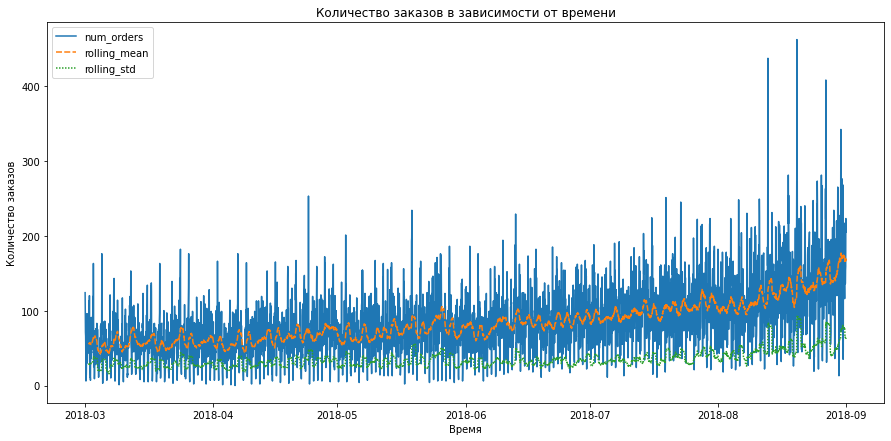

In [18]:
# Вычислим скользящее среднее 

taxi_1h["rolling_mean"] = taxi_1h["num_orders"].rolling(24).mean() # 24 часа в сутках
taxi_1h["rolling_std"] = taxi_1h["num_orders"].rolling(24).std()

# Построим график 

fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=taxi_1h, ax=ax)
ax.set_xlabel("Время")
ax.set_ylabel("Количество заказов")
ax.set_title("Количество заказов в зависимости от времени")
plt.show()

**Вывод**

В датафрейме представлены исторические данные в период с 1 марта по 31 августа 2018 года. Данные записаны с периодичностью 10 минут, поэтому мы их ресемплировали с промежутков в 1 час. Для анализа мы использовали графики тренда, сезонности и остатков. Так так 1 марта 2018 это четверг, поэтому при рассмотрении недель, лучше будет взять даты с понедельника по воскресение, мы выбрали неделю с 12 по 18 марта. По результатам анализа можно сделать следующие выводы: 
- Изначальная выборка достаточно стационарна.
- Линия тренда на общем графике плавно поднимается вверх, что указывает на рост значений с течением времени, на свой максимум выходит к концу августа.
- Линия тренда на графике одной недели показывает повышение количества заказов утром в понедельник, затем идет спад и плавный подъем к вечеру пятницы, пик приходится на ночь с пятницы на субботу, затем снова следует резкий спад в воскресенье. Эти колебания вполне объяснимы активностью жителей городов в конце рабочей недели. 
- График сезонности демонстрирует периодические колебания в течение суток. Можно увидеть, что в начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика. При этом сезонность остается неизменной на протяжении всего исследуемого периода.

## Обучение модели

### Подготовка данных 

In [19]:
# Функция для создания новых признаков

def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    #data['month'] = data.index.month
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
# Создадим новые признаки

taxi_full = make_features(taxi_1h, 24, 168) # 24 часа в сутках и 168 часов в неделю

# Проверим результат

print(taxi_full.info())
print(taxi_full.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4248 non-null   float64
 2   rolling_std   4393 non-null   float64
 3   hour          4416 non-null   int64  
 4   day           4416 non-null   int64  
 5   dayofweek     4416 non-null   int64  
 6   lag_1         4415 non-null   float64
 7   lag_2         4414 non-null   float64
 8   lag_3         4413 non-null   float64
 9   lag_4         4412 non-null   float64
 10  lag_5         4411 non-null   float64
 11  lag_6         4410 non-null   float64
 12  lag_7         4409 non-null   float64
 13  lag_8         4408 non-null   float64
 14  lag_9         4407 non-null   float64
 15  lag_10        4406 non-null   float64
 16  lag_11        4405 non-null   float64
 17  lag_12        4404 non-null

In [21]:
# Удалим пропущенные значения, возникшие при создании новых признаков

taxi_full = taxi_full.dropna()

# Проверим результат

print('Пропущенные значения в датафрейме: \n', taxi_full.isna().sum())

Пропущенные значения в датафрейме: 
 num_orders      0
rolling_mean    0
rolling_std     0
hour            0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
dtype: int64


In [22]:
# Удаляем целевой признак

X_taxi = taxi_full.drop('num_orders', axis=1)

# Сохраняем целевой признак

y_taxi = taxi_full['num_orders']

In [23]:
# Разбиваем данные на обучающую и тестовую выборки в соотношении 90:10.

X_train, X_test, y_train, y_test = train_test_split(
        X_taxi,
        y_taxi,
        random_state=RANDOM_STATE,
        shuffle=False,
        test_size=0.1
    )

###  Создание пайплайна

In [24]:
# Cоздаём пайплайн для модели LinearRegression

pipe_lin = Pipeline([
    ('models', LinearRegression())
])


In [25]:
# Создаем сетку гиперпараметров для модели LinearRegression

param_grid_lin = [
    {
        'models': [LinearRegression()],
    }
]

In [26]:
# Cоздаём пайплайн для модели DecisionTreeRegressor

pipe_tree = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [27]:
# Создаем сетку гиперпараметров для модели DecisionTreeRegressor

param_grid_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__min_samples_leaf': range(1, 8),
    }
]

In [28]:
# Cоздаём пайплайн для модели LGBMRegressor

pipe_lgbm = Pipeline([
    ('models', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

In [29]:
# Создаем сетку гиперпараметров для модели LGBMRegressor

param_grid_lgbm = [
    {
    'models': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
    'models__n_estimators': range(50, 100, 10),
    'models__max_depth': range(3, 8)
    }
]

In [30]:
# Cоздаём пайплайн для модели CatBoostRegressor

pipe_cat = Pipeline([
    ('models', CatBoostRegressor())
])

In [31]:
# Cоздаём пайплайн для модели CatBoostRegressor

param_grid_cat = [  
     {
        'models': [CatBoostRegressor()],
        'models__iterations': range(100, 200, 100),
        'models__depth': range(2, 10, 2)
    }
]

### Обучение модели 

In [32]:
def ml_model(X_train, y_train, pipe, param_grid):
    
    start_time = time.time()  # начинаем замер общего времени
    splits = TimeSeriesSplit(n_splits=3)

    # Поиск наилучшей модели
    randomized_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=30,
        cv=splits,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        error_score="raise",
    )
    
    randomized_search.fit(X_train, y_train)
    
    end_time = time.time()  # заканчиваем замер общего времени
    all_time = end_time - start_time
    print(f"Время полного процесса поиска: {all_time:.2f} секунд")
    
  # Информация о лучшей модели
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_rmse = (-1) * randomized_search.best_score_
    
    print('Лучшая модель:\n')
    print(best_model)
    print('Параметры лучшей модели:', best_params)
    print('RMSE лучшей модели на кросс-валидации:', best_rmse)
    
    return randomized_search

In [33]:
%%time
# Обучим модель линейной регрессии

model_lin = ml_model(X_taxi, y_taxi, pipe_lin, param_grid_lin)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время полного процесса поиска: 0.56 секунд
Лучшая модель:

Pipeline(steps=[('models', LinearRegression())])
Параметры лучшей модели: {'models': LinearRegression()}
RMSE лучшей модели на кросс-валидации: 30.33169412122338
CPU times: user 303 ms, sys: 295 ms, total: 598 ms
Wall time: 560 ms


In [34]:
%%time
# Обучим модель DecisionTreeRegressor

model_tree = ml_model(X_train, y_train, pipe_tree, param_grid_tree)

Время полного процесса поиска: 1.99 секунд
Лучшая модель:

Pipeline(steps=[('models',
                 DecisionTreeRegressor(max_depth=4, min_samples_leaf=6,
                                       random_state=42))])
Параметры лучшей модели: {'models__min_samples_leaf': 6, 'models__max_depth': 4, 'models': DecisionTreeRegressor(random_state=42)}
RMSE лучшей модели на кросс-валидации: 32.0354484595009
CPU times: user 1.97 s, sys: 7.25 ms, total: 1.98 s
Wall time: 1.99 s


In [35]:
%%time
# Обучим модель LGBMRegressor

model_lgbm = ml_model(X_train, y_train, pipe_lgbm, param_grid_lgbm)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Время полного процесса поиска: 32.11 секунд
Лучшая модель:

Pipeline(steps=[('models',
                 LGBMRegressor(max_depth=4, n_estimators=90, random_state=42,
                               verbose=-1))])
Параметры лучшей модели: {'models__n_estimators': 90, 'models__max_depth': 4, 'models': LGBMRegressor(random_state=42, verbose=-1)}
RMSE лучшей модели на кросс-валидации: 26.155012029875184
CPU times: user 31.4 s, sys: 296 ms, total: 31.7 s
Wall time: 32.1 s


In [36]:
%%time
# Обучим модель CatBoostRegressor

model_cat = ml_model(X_train, y_train, pipe_cat, param_grid_cat)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Learning rate set to 0.264384
0:	learn: 26.9514357	total: 47.1ms	remaining: 4.66s
1:	learn: 24.7841564	total: 47.9ms	remaining: 2.35s
2:	learn: 23.4856247	total: 48.6ms	remaining: 1.57s
3:	learn: 22.5790428	total: 49.3ms	remaining: 1.18s
4:	learn: 22.0082992	total: 50.1ms	remaining: 951ms
5:	learn: 21.4980917	total: 50.8ms	remaining: 796ms
6:	learn: 21.0193289	total: 51.6ms	remaining: 685ms
7:	learn: 20.7275797	total: 52.3ms	remaining: 602ms
8:	learn: 20.3229470	total: 52.9ms	remaining: 535ms
9:	learn: 20.1610656	total: 53.8ms	remaining: 484ms
10:	learn: 19.9496475	total: 54.6ms	remaining: 442ms
11:	learn: 19.7713245	total: 55.3ms	remaining: 406ms
12:	learn: 19.6168925	total: 56ms	remaining: 375ms
13:	learn: 19.4673568	total: 56.8ms	remaining: 349ms
14:	learn: 19.3747921	total: 57.5ms	remaining: 326ms
15:	learn: 19.2430989	total: 58.3ms	remaining: 306ms
16:	learn: 19.1566206	total: 59.1ms	remaining: 289ms
17:	learn: 18.9429035	total: 59.8ms	remaining: 272ms
18:	learn: 18.8485975	total:

**Выводы**

Для поиска лучших параметров моделей для предсказания количества заказов на следующий час был использован инструмент `RandomizedSearchCV`, который анализировал различные параметры для моделей `LinearRegression()`, `DecisionTreeRegressor()`, `LGBMRegressor()` и `CatBoostRegressor()`. 

По результатам метрики на кросс-валидации лучшей стала модель со следующими параметрами:  LGBMRegressor(max_depth=4, n_estimators=90, random_state=42, verbose=-1)).

## Тестирование и анализ модели.

Проверьте данные на тестовой выборке и сделайте выводы.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.


In [37]:
# Предскажем значения тестовой выборки

#LightGBM

lgbm_test_start_time = time.time()
pred_lgbm = model_lgbm.predict(X_test)
lgbm_test_total_time = time.time() - lgbm_test_start_time
mse_lgbm = mean_squared_error(y_test, pred_lgbm)
rmse_lgbm = math.sqrt(mse_lgbm)
print('Модель LightGBM')
print('RMSE на тестовой выборке:', rmse_lgbm)
print(f"Время полного процесса предсказания : {lgbm_test_total_time:.2f} секунд \n")



Модель LightGBM
RMSE на тестовой выборке: 42.338653057879924
Время полного процесса предсказания : 0.01 секунд 



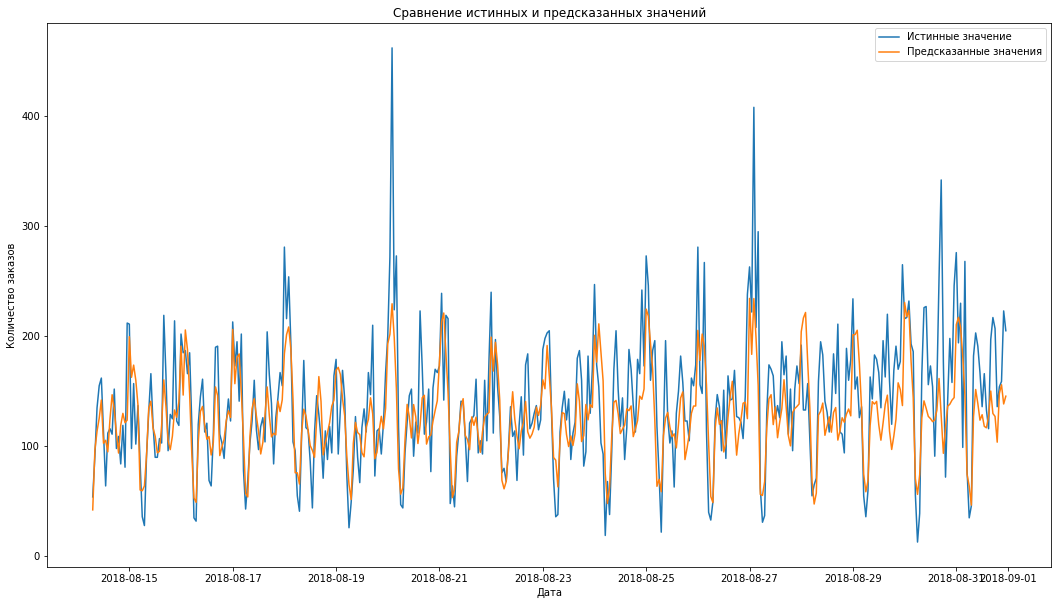

In [38]:
# Построим график сравнения истинных и предсказанных значений

predict = pd.DataFrame(pred_lgbm)
predict['date'] = y_test.index
predict = predict.set_index('date')


fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(y_test, label='Истинные значение')
ax.plot(predict, label='Предсказанные значения')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.set_title('Сравнение истинных и предсказанных значений')
ax.legend()
plt.show()

**Выводы**

Для выбора лучшей модели заказчику было важно учитывать качество предсказания, RMSE на тестовой выборке должно быть не больше 48.

Достигнув метрики RMSE в 26.15 на кросс-валидации, и 42.33 на тестовых данных, лучше всех себя показала модель `LGBMRegressor`. 
Обучение модели заняло 32.11 секунд, а время предсказания 0.01 секунды. Чуть хуже справились модели `CatBoost` (RMSE на кросс-валидации = 26.61).

График сравнения истинных и предсказанных значений демонтрирует, что в целом модель предсказывает меньшее количество заказов, чем есть на самом деле, но паттер колебаний практически одинаковый.

Модель LightGBM справилась лучше линейной регрессии и дерева решений, так как увереннее работает при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что в наших данных признаков с такой зависимостью много. Более того эта модель эффективно обрабатывает шумы и неоднородности данных, что обусловлено наличием методов регуляризации и мощным механизмом ансамблевого обучения. Однако бустинг обучается значительно дольше других моделей, но и точность предсказания у этой модели выше, поэтому рекомендуется ее использование для задачи определения цены автомобиля. Различия в результатах работы моделей с бустингом в целом незначительные.

## Выводы 

Для настоящего проекта нам были предоставлены исторические данные о заказах такси в аэропортах компании «Чётенькое такси». Для привлечения большего количества водителей в период пиковой нагрузки компании необходимо спрогнозировать количество заказов такси на следующий час.  

**Цель исследования**: Построить модель машинного обучения для предсказания количества заказов такси на следующий час на основе исторических данных.

В **первом разделе** мы загрузили данные и изучили общую информацию. Дубликатов и аномалий не обнаружено, пропусков нет. Для анализа нам был предоставлен датасет со следующими признаками:
- `num_orders` — количество заказов — **целевой признак**

Во **втором разделе** мы провели исследовательский анализ данных и сделали следующие выводы:
- В датафрейме представлены исторические данные в период с 1 марта по 31 августа 2018 года. Данные записаны с периодичностью 10 минут, поэтому мы их ресемплировали с промежутков в 1 час. 
- Изначальная выборка достаточно стационарна.
- Линия тренда на общем графике плавно поднимается вверх, что указывает на рост значений с течением времени, на свой максимум выходит к концу августа.
- Линия тренда на графике одной недели показывает повышение количества заказов утром в понедельник, затем идет спад и плавный подъем к вечеру пятницы, пик приходится на ночь с пятницы на субботу, затем снова следует резкий спад в воскресенье. Эти колебания вполне объяснимы активностью жителей городов в конце рабочей недели. 
- График сезонности демонстрирует периодические колебания в течение суток. Можно увидеть, что в начале каждого дня у нас пик, потом резкое падение, затем в течение дня количество заказов растет и к концу дня достигает нового пика. При этом сезонность остается неизменной на протяжении всего исследуемого периода.

Во **третьем разделе** для поиска лучших параметров моделей для предсказания цены автомобиля был использован инструмент `RandomizedSearchCV`, который анализировал различные параметры для моделей `LinearRegression()`, `DecisionTreeRegressor()`, `LGBMRegressor()` и `CatBoostRegressor()`. По результатам метрики на кросс-валидации лучшей стала модель со следующими параметрами:  LGBMRegressor(max_depth=4, n_estimators=90, random_state=42, verbose=-1)).

В **четвертом разделе** мы провели анализ работы обученных моделей на тестовой выборке данных. Для выбора лучшей модели заказчику было важно учитывать качество предсказания, RMSE на тестовой выборке должно быть не больше 48. Достигнув метрики RMSE в 26.15 на кросс-валидации, и 42.33 на тестовых данных, лучше всех себя показала модель `LGBMRegressor`. Обучение модели заняло 32.11 секунд, а время предсказания 0.01 секунды. Чуть хуже справились модели `CatBoost` (RMSE на кросс-валидации = 26.61). Различия в результатах работы моделей с бустингом в целом незначительные.

Таким образом, по итогам проведенного анализа была построена модель машинного обучения, способная предсказать количество заказов такси на следующий час.

<div class="alert alert-info"> <b>Комментарий студента:</b>
    
Спасибо большое за поддержку и ценные советы! Выводы откорректировала.</div>